In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-17 06:58:40--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-06-17 06:58:40 (8.09 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



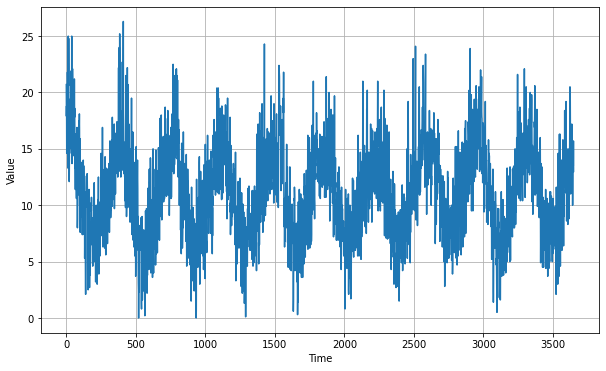

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i)

# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series [:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


# Sequence to sequence

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [8]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast
    # YOUR CODE HERE

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                       strides=1, padding='causal',activation='relu',
                       input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 12s 36ms/step - loss: 4.9022 - mae: 5.3789
Epoch 2/150
25/25 [==============================] - 1s 16ms/step - loss: 2.1842 - mae: 2.6435
Epoch 3/150
25/25 [==============================] - 1s 16ms/step - loss: 1.8379 - mae: 2.2895
Epoch 4/150
25/25 [==============================] - 0s 16ms/step - loss: 1.7738 - mae: 2.2243
Epoch 5/150
25/25 [==============================] - 1s 16ms/step - loss: 1.7231 - mae: 2.1727
Epoch 6/150
25/25 [==============================] - 1s 16ms/step - loss: 1.6967 - mae: 2.1452
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 1.6818 - mae: 2.1298
Epoch 8/150
25/25 [==============================] - 0s 16ms/step - loss: 1.6571 - mae: 2.1049
Epoch 9/150
25/25 [==============================] - 1s 16ms/step - loss: 1.6987 - mae: 2.1473
Epoch 10/150
25/25 [==============================] - 0s 15ms/step - loss: 1.6398 - mae: 2.0871
Epoch 11/150
25/25 [============================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

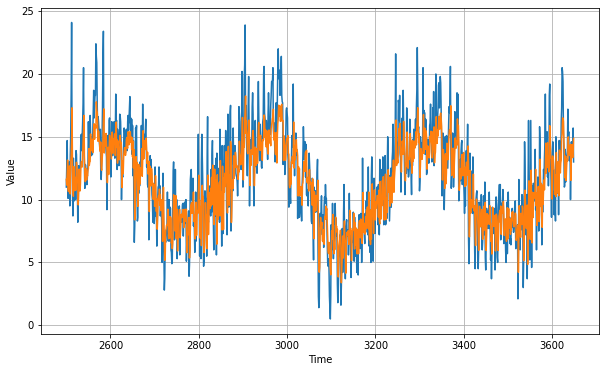

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8252964

In [13]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.609409  11.155937  12.291501  ... 13.338648  13.5580015 14.865807 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 1s 9ms/step - loss: 160.6578 - mae: 161.1574
Epoch 2/150
25/25 [==============================] - 0s 9ms/step - loss: 7.7101 - mae: 8.1988
Epoch 3/150
25/25 [==============================] - 0s 10ms/step - loss: 3.2152 - mae: 3.6866
Epoch 4/150
25/25 [==============================] - 0s 10ms/step - loss: 2.7926 - mae: 3.2607
Epoch 5/150
25/25 [==============================] - 0s 10ms/step - loss: 2.8383 - mae: 3.3062
Epoch 6/150
25/25 [==============================] - 0s 9ms/step - loss: 2.8047 - mae: 3.2718
Epoch 7/150
25/25 [==============================] - 0s 10ms/step - loss: 2.7714 - mae: 3.2385
Epoch 8/150
25/25 [==============================] - 0s 9ms/step - loss: 2.8001 - mae: 3.2679
Epoch 9/150
25/25 [==============================] - 0s 9ms/step - loss: 2.7908 - mae: 3.2580
Epoch 10/150
25/25 [==============================] - 0s 9ms/step - loss: 2.7879 - mae: 3.2551
Epoch 11/150
25/25 [==============================]

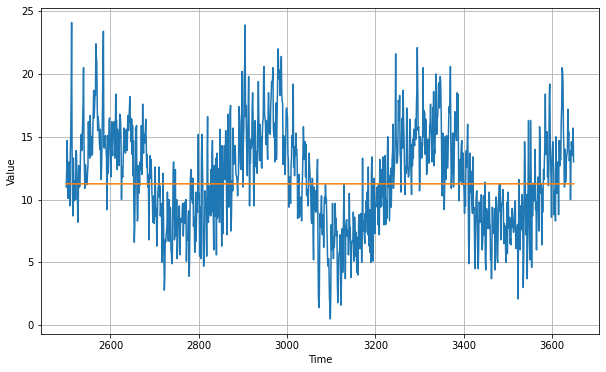

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE

tf.keras.layers.Dense(30, activation='relu',input_shape=[None,1]),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 3s 14ms/step - loss: 9.2370 - mae: 9.7270
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 3.9867 - mae: 4.4676
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 3.6883 - mae: 4.1680
Epoch 4/150
25/25 [==============================] - 0s 16ms/step - loss: 3.4090 - mae: 3.8870
Epoch 5/150
25/25 [==============================] - 0s 14ms/step - loss: 3.2171 - mae: 3.6934
Epoch 6/150
25/25 [==============================] - 0s 14ms/step - loss: 2.8873 - mae: 3.3605
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 2.5551 - mae: 3.0220
Epoch 8/150
25/25 [==============================] - 1s 16ms/step - loss: 2.4322 - mae: 2.8972
Epoch 9/150
25/25 [==============================] - 0s 15ms/step - loss: 2.4851 - mae: 2.9516
Epoch 10/150
25/25 [==============================] - 0s 15ms/step - loss: 2.4832 - mae: 2.9504
Epoch 11/150
25/25 [=============================

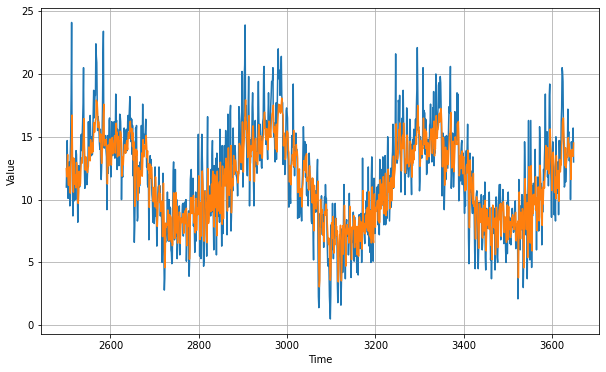

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

# Sequence to value


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[-1]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [15]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast
    # YOUR CODE HERE

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                       strides=1, padding='causal',activation='relu',
                       input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 5.1981 - mae: 5.6769
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 2.6592 - mae: 3.1243
Epoch 3/150
25/25 [==============================] - 1s 16ms/step - loss: 2.6197 - mae: 3.0849
Epoch 4/150
25/25 [==============================] - 0s 16ms/step - loss: 2.3598 - mae: 2.8209
Epoch 5/150
25/25 [==============================] - 1s 15ms/step - loss: 2.3236 - mae: 2.7834
Epoch 6/150
25/25 [==============================] - 0s 15ms/step - loss: 2.3426 - mae: 2.8039
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 2.2633 - mae: 2.7234
Epoch 8/150
25/25 [==============================] - 1s 16ms/step - loss: 2.2417 - mae: 2.7002
Epoch 9/150
25/25 [==============================] - 0s 15ms/step - loss: 2.2951 - mae: 2.7551
Epoch 10/150
25/25 [==============================] - 1s 16ms/step - loss: 2.2618 - mae: 2.7210
Epoch 11/150
25/25 [=============================

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

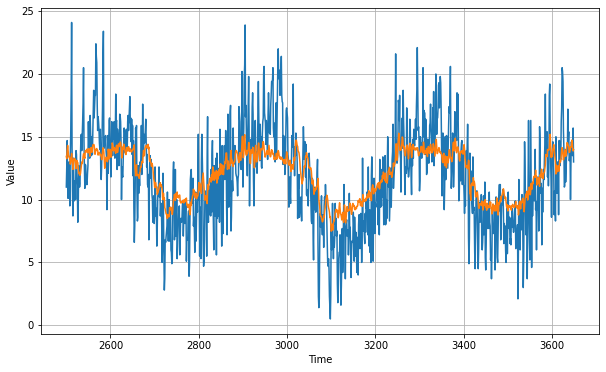

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.2542477

In [20]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[13.440733 13.260752 13.973832 ... 14.052163 13.869676 13.985803]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 7.7764 - mae: 8.2539
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 2.8716 - mae: 3.3386
Epoch 3/150
25/25 [==============================] - 1s 16ms/step - loss: 3.5806 - mae: 4.0561
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 2.5243 - mae: 2.9869
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 2.5530 - mae: 3.0162
Epoch 6/150
25/25 [==============================] - 1s 16ms/step - loss: 3.5345 - mae: 4.0100
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 3.4995 - mae: 3.9753
Epoch 8/150
25/25 [==============================] - 0s 15ms/step - loss: 2.4468 - mae: 2.9086
Epoch 9/150
25/25 [==============================] - 1s 16ms/step - loss: 2.3813 - mae: 2.8428
Epoch 10/150
25/25 [==============================] - 0s 15ms/step - loss: 3.2082 - mae: 3.6817
Epoch 11/150
25/25 [=============================

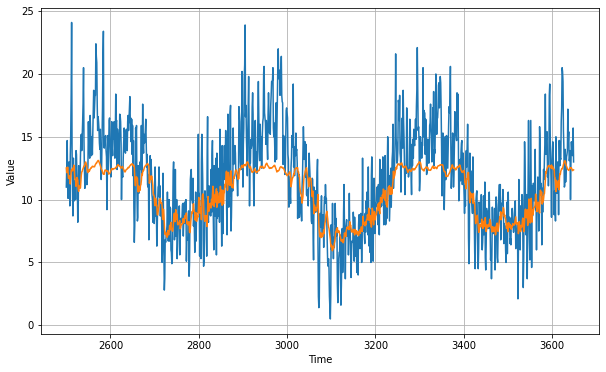

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
 ds = ds.map(lambda x: (x[:-1], x[-1]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE

tf.keras.layers.Dense(30, activation='relu',input_shape=[None,1]),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[-1]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS